In [159]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import geopandas as gpd
import numpy as np
from tqdm import tqdm_notebook
from shapely.geometry import Point, LineString
import os

from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import folium
import geoplot


data_path = '/home/fterroso/data/'
tweets_path = '/home/fterroso/projects/twitter-crawler/streaming_tweets/'

## Province data

In [160]:
province_with_pob_gdf =gpd.read_file(os.path.join('data', 'province_w_population.geojson'), driver='GeoJSON', encoding='utf-8')
province_with_pob_gdf['CODEUNIT'] = province_with_pob_gdf['CODEUNIT'].astype(int)

In [161]:
province_with_pob_gdf.head()

,NATCODE,NAMEUNIT,CODEUNIT,2019,geometry
0,34104600000,València/Valencia,46,2565124.0,(POLYGON ((653037.6610938488 4429500.236400451...
1,34084500000,Toledo,45,694844.0,"POLYGON ((294238.4652867644 4416957.42816667, ..."
2,34024400000,Teruel,44,134137.0,"POLYGON ((765333.0112961649 4512252.350615062,..."
3,34094300000,Tarragona,43,804664.0,(POLYGON ((813560.4348489635 4504876.753000001...
4,34074200000,Soria,42,88636.0,"POLYGON ((583890.5889343297 4603311.305096235,..."


## Twitter OD matrix

In [162]:
def enrich_tw_od_fn(od_df):
    od_df.reset_index(inplace=True)
    result_df= pd.merge(od_df, province_with_pob_gdf['NAMEUNIT CODEUNIT'.split()], left_on='PROV_o', right_on='NAMEUNIT')
    result_df.drop(columns='NAMEUNIT',inplace=True) 
    result_df.rename(columns={'CODEUNIT':'CPROV_o'}, inplace=True)
    #print(result_df)
    result_df= pd.merge(result_df, province_with_pob_gdf['NAMEUNIT CODEUNIT'.split()], left_on='PROV_d', right_on='NAMEUNIT')
    result_df.drop(columns='NAMEUNIT',inplace=True)
    result_df.rename(columns={'CODEUNIT':'CPROV_d'}, inplace=True)
    
    
    result_df.set_index('CPROV_o CPROV_d'.split(), inplace=True)
    
    return result_df

Read OD matrix with population from notebook 5.

In [163]:
#context = 'global'
context = 'july'

In [164]:
tw_od_df = pd.read_csv(os.path.join('data', '{}_tw_od_normalized_enriched.csv'.format(context)), index_col=0)

In [165]:
tw_od_df.head()

,PROV_d,n_trips,n_trips_norm,distance,pob_o
PROV_o,,,,,
A Coruña,Araba/Álava,1,0.022727,469.926541,1119596.0
A Coruña,Asturias,2,0.045455,201.994568,1119596.0
A Coruña,Barcelona,4,0.090909,873.536912,1119596.0
A Coruña,Bizkaia,1,0.022727,456.738156,1119596.0
A Coruña,León,1,0.022727,221.969335,1119596.0


In [166]:
tw_od_w_codes_df = enrich_tw_od_fn(tw_od_df)

In [167]:
tw_od_w_codes_df.shape

(852, 6)

In [168]:
tw_od_w_codes_df.head()

,,PROV_o,PROV_d,n_trips,n_trips_norm,distance,pob_o
CPROV_o,CPROV_d,,,,,,
15,1,A Coruña,Araba/Álava,1,0.022727,469.926541,1119596.0
8,1,Barcelona,Araba/Álava,2,0.006472,406.977101,5664579.0
48,1,Bizkaia,Araba/Álava,5,0.080645,46.047449,1152651.0
9,1,Burgos,Araba/Álava,5,0.053763,88.068059,356958.0
39,1,Cantabria,Araba/Álava,1,0.020833,114.115095,581078.0


In [169]:
tw_od_w_codes_df.to_csv(os.path.join('data', '{}_tw_od_normalized_w_names_enriched.csv'.format(context)))

# Province data

In [170]:
province_gdf = gpd.read_file(os.path.join('data', 'province_w_population.geojson'),
                             encoding='utf-8').to_crs({'init': 'epsg:25830'})
province_gdf['CODEUNIT'] = province_gdf['CODEUNIT'].astype(int)
province_gdf.head()

,NATCODE,NAMEUNIT,CODEUNIT,2019,geometry
0,34104600000,València/Valencia,46,2565124.0,(POLYGON ((653037.6610938488 4429500.236400452...
1,34084500000,Toledo,45,694844.0,"POLYGON ((294238.4652867644 4416957.42816667, ..."
2,34024400000,Teruel,44,134137.0,"POLYGON ((765333.0112961649 4512252.350615062,..."
3,34094300000,Tarragona,43,804664.0,(POLYGON ((813560.4348489635 4504876.753000001...
4,34074200000,Soria,42,88636.0,"POLYGON ((583890.5889343297 4603311.305096234,..."


In [171]:
province_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
NATCODE     50 non-null object
NAMEUNIT    50 non-null object
CODEUNIT    50 non-null int64
2019        50 non-null float64
geometry    50 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 2.0+ KB


## Ground truth OD matrix

In [172]:
gt_od_df = pd.read_csv(os.path.join('data', 'Julio-Viajes-Normalizado_sinTotales.csv'), 
                       sep=';',
                       decimal=',',
                       header=None)

In [173]:
gt_od_df.columns= 'CPROV_o CPROV_d total_trips norm_trips'.split()

In [174]:
gt_od_df.set_index('CPROV_o CPROV_d'.split(), inplace=True)

In [175]:
gt_od_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3109 entries, (1, 2) to (384, 383)
Data columns (total 2 columns):
total_trips    3109 non-null float64
norm_trips     3109 non-null float64
dtypes: float64(2)
memory usage: 55.7 KB


In [176]:
gt_od_df.head()

total_trips  norm_trips
CPROV_o CPROV_d                         
1       2            186.866    0.000466
        3           2078.560    0.005188
        4            369.607    0.000923
        5            392.358    0.000979
        6            790.962    0.001974

### Enrich OD with meta-data

In [177]:
def calculate_distances_fn(row):
    po = row['PROV_o']
    pd_ = row['PROV_d']
    #print(po,pd_)
    po_centroid = province_gdf[province_gdf['NAMEUNIT']==po]['geometry'].iloc[0].centroid
    pd_centroid = province_gdf[province_gdf['NAMEUNIT']==pd_]['geometry'].iloc[0].centroid
    return po_centroid.distance(pd_centroid)/1000

In [178]:
def enrich_od_matrix_fn(od_df_):
    
    od_w_names_df = pd.merge(od_df_.reset_index(),
                            province_gdf['NAMEUNIT CODEUNIT'.split()],
                            left_on='CPROV_o', 
                            right_on='CODEUNIT')
    od_w_names_df.drop(columns='CODEUNIT', inplace=True)
    od_w_names_df.rename(columns={'NAMEUNIT':'PROV_o'}, inplace=True)
    
    od_w_names_df = pd.merge(od_w_names_df,
                            province_gdf['NAMEUNIT CODEUNIT'.split()],
                            left_on='CPROV_d', 
                            right_on='CODEUNIT')
    od_w_names_df.drop(columns='CODEUNIT', inplace=True)
    od_w_names_df.rename(columns={'NAMEUNIT':'PROV_d'}, inplace=True)
    
    od_w_names_df.set_index('CPROV_o CPROV_d'.split(),inplace=True)

    od_w_names_df['distance'] = od_w_names_df.apply(calculate_distances_fn, axis=1)
    
    od_w_names_df = pd.merge(od_w_names_df.reset_index(), province_gdf['NAMEUNIT 2019'.split()], how='left', left_on='PROV_o', right_on='NAMEUNIT')
    od_w_names_df.drop(columns='NAMEUNIT',inplace=True)
    od_w_names_df.rename(columns={'2019':'pob_o'}, inplace=True)
    
    od_w_names_df.set_index('CPROV_o CPROV_d'.split(),inplace=True)

    
    return od_w_names_df

In [179]:
gt_od_w_names_df = enrich_od_matrix_fn(gt_od_df)
gt_od_w_names_df.head()

,,total_trips,norm_trips,PROV_o,PROV_d,distance,pob_o
CPROV_o,CPROV_d,,,,,,
1,2,186.866,0.000466,Araba/Álava,Albacete,449.475826,331549.0
3,2,82287.488,0.057087,Alacant/Alicante,Albacete,128.697310,1858683.0
4,2,3247.865,0.009363,Almería,Albacete,183.628143,716820.0
5,2,471.007,0.001318,Ávila,Albacete,319.635676,157640.0
6,2,541.672,0.001992,Badajoz,Albacete,361.923358,673559.0


-------------------------------------------

In [180]:
tw_od_w_codes_df['gt_norm_trips']= gt_od_w_names_df['norm_trips']

In [181]:
tw_od_w_codes_df.fillna(0, axis=1,inplace=True)

In [182]:
tw_od_w_codes_df.head()

,,PROV_o,PROV_d,n_trips,n_trips_norm,distance,pob_o,gt_norm_trips
CPROV_o,CPROV_d,,,,,,,
15,1,A Coruña,Araba/Álava,1,0.022727,469.926541,1119596.0,0.000891
8,1,Barcelona,Araba/Álava,2,0.006472,406.977101,5664579.0,0.001722
48,1,Bizkaia,Araba/Álava,5,0.080645,46.047449,1152651.0,0.221205
9,1,Burgos,Araba/Álava,5,0.053763,88.068059,356958.0,0.049137
39,1,Cantabria,Araba/Álava,1,0.020833,114.115095,581078.0,0.029992


In [183]:
gt_od_w_names_df['tw_n_trips']= tw_od_w_codes_df['n_trips']
gt_od_w_names_df['tw_n_trips_norm']= tw_od_w_codes_df['n_trips_norm']

In [184]:
gt_od_w_names_df.shape

(2308, 8)

In [185]:
gt_od_w_names_df.fillna(0, axis=1,inplace=True)

In [186]:
gt_od_w_names_df.head()

,,total_trips,norm_trips,PROV_o,PROV_d,distance,pob_o,tw_n_trips,tw_n_trips_norm
CPROV_o,CPROV_d,,,,,,,,
1,2,186.866,0.000466,Araba/Álava,Albacete,449.475826,331549.0,0.0,0.000000
3,2,82287.488,0.057087,Alacant/Alicante,Albacete,128.697310,1858683.0,4.0,0.058824
4,2,3247.865,0.009363,Almería,Albacete,183.628143,716820.0,0.0,0.000000
5,2,471.007,0.001318,Ávila,Albacete,319.635676,157640.0,0.0,0.000000
6,2,541.672,0.001992,Badajoz,Albacete,361.923358,673559.0,0.0,0.000000


In [187]:
gt_od_w_names_df.to_csv(os.path.join('data','global_gt_july_2017_od.csv'))

# 0. Diversity of trips comparative

In [188]:
gt_od_w_names_df.groupby('CPROV_o').count()['total_trips'].to_frame()

,total_trips
CPROV_o,
1,47
2,47
3,48
4,48
5,47
6,48
8,48
9,48
10,48


In [189]:
n_trips_gt_df= gt_od_w_names_df.groupby('CPROV_o').count()['total_trips'].to_frame()
n_trips_gt_df['type'] = 'in'
n_trips_gt_df['source'] = 'M'
n_trips_gt_df.head()

,total_trips,type,source
CPROV_o,,,
1,47,in,M
2,47,in,M
3,48,in,M
4,48,in,M
5,47,in,M


In [190]:
def get_number_of_trips(df_,target_column, source):
    target_column_keys = {'o':'outgoing', 'd': 'incoming'}
    n_trips_df= df_.groupby('CPROV_{}'.format(target_column)).count()['PROV_o'].to_frame()
    n_trips_df['type of trip'] = target_column_keys[target_column]
    n_trips_df['source'] = source
    
    return n_trips_df

In [191]:
def generate_trip_distribution_df_fn(gt_df, tw_df, min_trip_rate):
    
    _gt_df = gt_df[gt_df['norm_trips']> min_trip_rate]
    _tw_df = tw_df[tw_df['n_trips_norm']> min_trip_rate]
    
    in_gt_df = get_number_of_trips(_gt_df, 'o', 'M')
    out_gt_df = get_number_of_trips(_gt_df, 'd', 'M')

    in_twt_df = get_number_of_trips(_tw_df, 'o', 'TWT')
    out_twt_df = get_number_of_trips(_tw_df, 'd', 'TWT')
    
    """
    n_trips_gt_df= _gt_df.groupby(target_column).count()
    
    n_trips_twt_df= _tw_df.groupby(target_column).count()

    n_trips_twt_df['M'] = _gt_df.groupby(target_column).count()['PROV_o']
    trips_dist_df = n_trips_twt_df['M PROV_o'.split()]
        return trips_dist_df.rename(columns={'PROV_o':'TWT'})
    """
    
    _df=  pd.concat([in_gt_df, out_gt_df, in_twt_df, out_twt_df])
    return _df.rename(columns={'PROV_o':'num of destinations'})



In [192]:
min_trip_rate= 0
trips_dist_df = generate_trip_distribution_df_fn(gt_od_w_names_df, tw_od_w_codes_df, min_trip_rate)

In [193]:
trips_dist_df.head()

,num of destinations,type of trip,source
1,47,outgoing,M
2,47,outgoing,M
3,48,outgoing,M
4,48,outgoing,M
5,47,outgoing,M


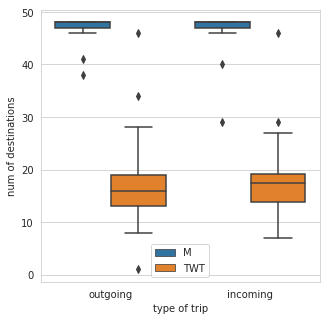

In [194]:
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
sns.boxplot(data=trips_dist_df, x='type of trip', y='num of destinations', hue='source'); #,showfliers = False);
plt.legend(loc='lower center')
plt.savefig(os.path.join('figs', 'dist_trips_in_out_{}.png'.format(min_trip_rate)))

# 1. Global comparative

### 1.1 Global correlation factor

In [195]:
tw_od_w_codes_df['n_trips_norm'].corr(tw_od_w_codes_df['gt_norm_trips'])

0.7733224382717955

In [196]:
gt_od_w_names_df['norm_trips'].corr(gt_od_w_names_df['tw_n_trips_norm'])

0.7679423363888149

In [197]:
tw_od_w_codes_df.loc[28]

,PROV_o,PROV_d,n_trips,n_trips_norm,distance,pob_o,gt_norm_trips
CPROV_d,,,,,,,
1,Madrid,Araba/Álava,4,0.006135,272.772997,6663394.0,0.003052
33,Madrid,Asturias,2,0.003067,363.791473,6663394.0,0.014296
8,Madrid,Barcelona,48,0.073620,498.069177,6663394.0,0.021159
48,Madrid,Bizkaia,9,0.013804,312.961798,6663394.0,0.006348
24,Madrid,León,13,0.019939,295.152042,6663394.0,0.009325
27,Madrid,Lugo,3,0.004601,417.481255,6663394.0,0.003034
32,Madrid,Ourense,2,0.003067,375.499588,6663394.0,0.002564
36,Madrid,Pontevedra,1,0.001534,451.363573,6663394.0,0.007433
47,Madrid,Valladolid,25,0.038344,158.138385,6663394.0,0.015828


### 1.2 RMSE

In [198]:
from sklearn.metrics import mean_squared_error

In [199]:
mean_squared_error(tw_od_w_codes_df['gt_norm_trips'], tw_od_w_codes_df['n_trips_norm'])

0.004516207479537795

In [200]:
mean_squared_error(gt_od_w_names_df['norm_trips'], gt_od_w_names_df['tw_n_trips_norm'])

0.002055299052777528

-----------------------

# 2. Population-based comparison

In [201]:
gt_od_w_names_df.head()

,,total_trips,norm_trips,PROV_o,PROV_d,distance,pob_o,tw_n_trips,tw_n_trips_norm
CPROV_o,CPROV_d,,,,,,,,
1,2,186.866,0.000466,Araba/Álava,Albacete,449.475826,331549.0,0.0,0.000000
3,2,82287.488,0.057087,Alacant/Alicante,Albacete,128.697310,1858683.0,4.0,0.058824
4,2,3247.865,0.009363,Almería,Albacete,183.628143,716820.0,0.0,0.000000
5,2,471.007,0.001318,Ávila,Albacete,319.635676,157640.0,0.0,0.000000
6,2,541.672,0.001992,Badajoz,Albacete,361.923358,673559.0,0.0,0.000000


In [202]:
min_pop = gt_od_w_names_df['pob_o'].min()
max_pop = gt_od_w_names_df['pob_o'].max()
pop_ranges = np.linspace(min_pop, max_pop, 10)

In [203]:
pop_ranges= np.arange(0,7000001,500000)

In [204]:
pop_ranges

array([      0,  500000, 1000000, 1500000, 2000000, 2500000, 3000000,
       3500000, 4000000, 4500000, 5000000, 5500000, 6000000, 6500000,
       7000000])

In [205]:
t_od_df = gt_od_w_names_df[(gt_od_w_names_df['pob_o']>=84777)&(gt_od_w_names_df['pob_o']<815734)]

In [206]:
t_od_df.head()

,,total_trips,norm_trips,PROV_o,PROV_d,distance,pob_o,tw_n_trips,tw_n_trips_norm
CPROV_o,CPROV_d,,,,,,,,
1,2,186.866,0.000466,Araba/Álava,Albacete,449.475826,331549.0,0.0,0.000000
4,2,3247.865,0.009363,Almería,Albacete,183.628143,716820.0,0.0,0.000000
5,2,471.007,0.001318,Ávila,Albacete,319.635676,157640.0,0.0,0.000000
6,2,541.672,0.001992,Badajoz,Albacete,361.923358,673559.0,0.0,0.000000
9,2,753.523,0.001965,Burgos,Albacete,415.912502,356958.0,1.0,0.010753


In [207]:
t_od_df['PROV_o'].nunique()

35

In [208]:
def compare_per_time_hour(od_df_, tw_total_trips, gt_total_trips):
    corr_= round(od_df_['norm_trips'].corr(od_df_['tw_n_trips_norm']),3)
    rmse = round(mean_squared_error(od_df_['norm_trips'], od_df_['tw_n_trips_norm'],squared=False),3)
        
    tw_trip_rate = round(od_df_['tw_n_trips'].sum()/tw_total_trips,3)
    gt_trip_rate = round(od_df_['total_trips'].sum()/gt_total_trips,3)
    
    n_provinces = round(t_od_df['PROV_o'].nunique(),3)
    
    return corr_, rmse, tw_trip_rate, gt_trip_rate, n_provinces

In [209]:
tw_total_trips = gt_od_w_names_df['tw_n_trips'].sum()
gt_total_trips = gt_od_w_names_df['total_trips'].sum()

In [210]:
pop_results = []
for pi,pj in zip(pop_ranges, pop_ranges[1:]):
    t_od_df = gt_od_w_names_df[(gt_od_w_names_df['pob_o']>=pi)&(gt_od_w_names_df['pob_o']<pj)]
    if not t_od_df.empty:
        print(pi, pj, t_od_df['tw_n_trips'].sum(), t_od_df['total_trips'].sum())
        """
        corr_= t_od_df['norm_trips'].corr(t_od_df['tw_n_trips_norm'])
        rmse = mean_squared_error(t_od_df['norm_trips'], t_od_df['tw_n_trips_norm'],squared=False)
        
        tw_trip_rate = t_od_df['tw_n_trips'].sum()/tw_total_trips
        gt_trip_rate = t_od_df['total_trips'].sum()/gt_total_trips
        pop_results.append(('{:.0f}-{:.0f}'.format(pi,pj),corr_, rmse, tw_trip_rate, gt_trip_rate)
        """
        corr_, rmse, tw_trip_rate, gt_trip_rate, n_provinces = compare_per_time_hour(t_od_df, tw_total_trips, gt_total_trips)
        pop_results.append(('{:.0f}-{:.0f}'.format(pi,pj), n_provinces, gt_trip_rate, tw_trip_rate, corr_, rmse, ))
    

0 500000 1049.0 5715428.99
500000 1000000 1048.0 8723204.149
1000000 1500000 230.0 3419136.931
1500000 2000000 309.0 3117033.551
2500000 3000000 106.0 1183576.215
5500000 6000000 300.0 2248867.0759999994
6500000 7000000 646.0 3224166.457


In [211]:
pop_results_df = pd.DataFrame.from_records(pop_results, columns='pop-range num_provinces GT-rate TWT-rate PC RMSE'.split())
pop_results_df.set_index('pop-range', inplace=True)
pop_results_df

,num_provinces,GT-rate,TWT-rate,PC,RMSE
pop-range,,,,,
0-500000,22,0.207,0.284,0.667,0.055
500000-1000000,16,0.316,0.284,0.893,0.033
1000000-1500000,5,0.124,0.062,0.763,0.045
1500000-2000000,3,0.113,0.084,0.757,0.041
2500000-3000000,1,0.043,0.029,0.752,0.038
5500000-6000000,1,0.081,0.081,0.894,0.030
6500000-7000000,1,0.117,0.175,0.840,0.025


In [212]:
pop_results_df.sum()

num_provinces    49.000
GT-rate           1.001
TWT-rate          0.999
PC                5.566
RMSE              0.267
dtype: float64

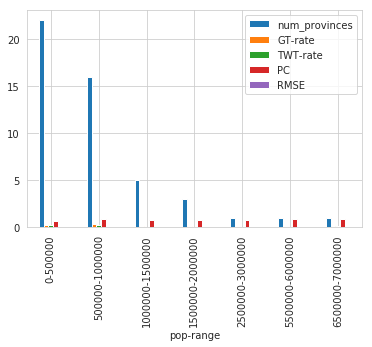

In [213]:
pop_results_df.plot(kind='bar', grid=True);

-------------------------------------

# 3. Time-based comparison

In [214]:
time_od_df = pd.read_csv(os.path.join('data', 'Julio_Horas_ProvinciaxProvincia.csv'), 
                          sep=';', 
                          converters={3: lambda x: float(x.replace('.','').replace(',','.')),
                                     4: lambda x: float(x.replace('.','').replace(',','.')),
                                     5: lambda x: float(x.replace('.','').replace(',','.')),},
                          encoding = "ISO-8859-1",
                         header=None)
time_od_df.columns= 'time_period CPROV_o CPROV_d n_trips norm_trips total_trips_PROV_o'.split()
time_od_df.set_index('CPROV_o CPROV_d'.split(), inplace=True)
time_od_df.head()

time_period  n_trips  norm_trips  total_trips_PROV_o
CPROV_o CPROV_d                                                     
1       2                P1   13.669    0.000316           43230.266
        3                P1  624.128    0.014437           43230.266
        4                P1  120.043    0.002777           43230.266
        5                P1   26.636    0.000616           43230.266
        6                P1  146.481    0.003388           43230.266

Here we calculate the rate of trips per hour in the ministry study

In [215]:
norm_time_od_df = time_od_df.groupby('time_period').sum()

In [216]:
total_trips = norm_time_od_df['n_trips'].sum()

In [217]:
norm_time_od_df['n_trips'] = norm_time_od_df['n_trips'] / total_trips

In [218]:
norm_time_od_df

,n_trips,norm_trips,total_trips_PROV_o
time_period,,,
P1,0.091123,59.0,1.406245e+08
P2,0.217822,59.0,3.357502e+08
P3,0.401079,59.0,6.211797e+08
P4,0.289976,59.0,4.204424e+08


In [219]:
#norm_time_od_df = time_od_df.groupby('time_period').count('n_trips')
#norm_time_od_df -= norm_time_od_df.min()
#norm_time_od_df -= norm_time_od_df.max()

In [220]:
time_od_enrich_df= enrich_od_matrix_fn(time_od_df)

In [221]:
def get_comparison_by_time_period(tw_time_od_df, gt_time_od_df_, time_period=None):
    
    if time_period:
        gt_od_df_ = gt_time_od_df_[gt_time_od_df_['time_period']==time_period]
    else:
        gt_od_df_ = gt_time_od_df_
    
    time_od_enriched_df = enrich_tw_od_fn(tw_time_od_df)
    gt_od_df_['tw_norm_trips']= time_od_enriched_df['n_trips_norm']
    gt_od_df_['tw_n_trips']= time_od_enriched_df['n_trips']
    gt_od_df_.fillna(0, axis=1, inplace=True)
   
    if time_period:
        gt_od_df_.to_csv(os.path.join('data','{}_gt_od_enriched_{}.csv'.format(context, time_period)))
    
    corr_= gt_od_df_['norm_trips'].corr(gt_od_df_['tw_norm_trips'])
    corr_by_dest_df = gt_od_df_.reset_index().groupby('CPROV_o')['tw_norm_trips norm_trips'.split()].corr()
    rmse = mean_squared_error(gt_od_df_['norm_trips'], gt_od_df_['tw_norm_trips'])
    return {'corr':corr_, 'corr_by_dest': corr_by_dest_df, 'rmse': rmse}

In [222]:
time_results = []

### 3.1 P1 (00:00-06:00)

Read time-period csv files generated in notebook 4b

In [223]:
tw_od_p1_df = pd.read_csv(os.path.join('data', '{}_tw_od_P1.csv'.format(context)), index_col=0)

In [224]:
tw_od_p1_df.head(3)

,PROV_d,n_trips,n_trips_norm
PROV_o,,,
A Coruña,Ourense,1,0.333333
A Coruña,Pontevedra,2,0.666667
Alacant/Alicante,Granada,2,0.285714


In [225]:
twt_total_trips = [tw_od_p1_df['n_trips'].sum()]

In [226]:
p1_comparison = get_comparison_by_time_period(tw_od_p1_df, time_od_enrich_df.copy(), 'P1')
time_results.append(('00:00-06:00', p1_comparison['corr'], p1_comparison['rmse']))
print(p1_comparison['corr'], p1_comparison['rmse'])

0.4415476409016671 0.006012391952878025


/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/fterroso/python/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pyd

### 3.2 P2 (06:00-10:00)

In [227]:
tw_od_p2_df = pd.read_csv(os.path.join('data', '{}_tw_od_P2.csv'.format(context)), index_col=0)
tw_od_p2_df.head()

,PROV_d,n_trips,n_trips_norm
PROV_o,,,
A Coruña,Barcelona,3,0.300
A Coruña,Lugo,2,0.200
A Coruña,Ourense,2,0.200
A Coruña,Pontevedra,3,0.300
Alacant/Alicante,Albacete,1,0.125


In [228]:
twt_total_trips.append(tw_od_p2_df['n_trips'].sum())

In [229]:
p2_comparison = get_comparison_by_time_period(tw_od_p2_df, time_od_enrich_df.copy(), 'P2')
time_results.append(('06:00-10:00', p2_comparison['corr'], p2_comparison['rmse']))
print(p2_comparison['corr'], p2_comparison['rmse'])

/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


0.6411493000963755 0.0033384304423007844


/home/fterroso/python/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### 3.3 P3 (10:00-17:00)

In [230]:
tw_od_p3_df = pd.read_csv(os.path.join('data', '{}_tw_od_P3.csv'.format(context)), index_col=0)
tw_od_p3_df.head()

,PROV_d,n_trips,n_trips_norm
PROV_o,,,
A Coruña,Araba/Álava,1,0.04
A Coruña,Asturias,1,0.04
A Coruña,Bizkaia,1,0.04
A Coruña,León,1,0.04
A Coruña,Lugo,5,0.20


In [231]:
twt_total_trips.append(tw_od_p3_df['n_trips'].sum())

In [232]:
p3_comparison = get_comparison_by_time_period(tw_od_p3_df, time_od_enrich_df.copy(), 'P3')
time_results.append(('10:00-17:00', p3_comparison['corr'], p3_comparison['rmse']))
print(p3_comparison['corr'], p3_comparison['rmse'])

/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/fterroso/python/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pyd

0.7626905122915342 0.002074679677398553


### 3.4 P4(17:00-00:00)

In [233]:
tw_od_p4_df = pd.read_csv(os.path.join('data', '{}_tw_od_P4.csv'.format(context)), index_col=0)
tw_od_p4_df.head()

,PROV_d,n_trips,n_trips_norm
PROV_o,,,
A Coruña,Asturias,1,0.166667
A Coruña,Barcelona,1,0.166667
A Coruña,Pontevedra,4,0.666667
Alacant/Alicante,Granada,1,0.125000
Alacant/Alicante,Guadalajara,1,0.125000


In [234]:
twt_total_trips.append(tw_od_p4_df['n_trips'].sum())

In [235]:
p4_comparison = get_comparison_by_time_period(tw_od_p4_df, time_od_enrich_df.copy(), 'P4')
time_results.append(('17:00-00:00', p4_comparison['corr'], p4_comparison['rmse']))
print(p4_comparison['corr'], p4_comparison['rmse'])

/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/fterroso/python/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pyd

0.6596933721303841 0.004699508969640732


In [236]:
time_results_df = pd.DataFrame.from_records(time_results)
time_results_df.set_index(0, inplace=True)
time_results_df.head()

,1,2
0,,
00:00-06:00,0.441548,0.006012
06:00-10:00,0.641149,0.003338
10:00-17:00,0.762691,0.002075
17:00-00:00,0.659693,0.004700


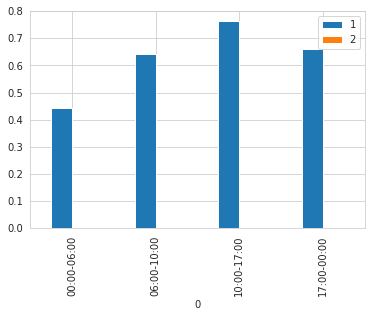

In [237]:
time_results_df.plot(kind='bar', grid=True);

In [238]:
twt_total_trips

[393, 1060, 1757, 548]

In [239]:
total_trips= sum(twt_total_trips)

In [240]:
twt_total_trips / total_trips

array([0.1045769 , 0.28206493, 0.46753592, 0.14582225])

# 4. Distribution of trips comparison

In [241]:
gt_od_w_names_df['norm_trips_rank']= gt_od_w_names_df.groupby('CPROV_o')['norm_trips'].rank(ascending=False)

In [242]:
gt_od_w_names_df['tw_trips_rank']= gt_od_w_names_df.groupby('CPROV_o')['tw_n_trips_norm'].rank(ascending=False, method='first')

In [243]:
gt_od_w_names_df.head()

,,total_trips,norm_trips,PROV_o,PROV_d,distance,pob_o,tw_n_trips,tw_n_trips_norm,norm_trips_rank,tw_trips_rank
CPROV_o,CPROV_d,,,,,,,,,,
1,2,186.866,0.000466,Araba/Álava,Albacete,449.475826,331549.0,0.0,0.000000,45.0,17.0
3,2,82287.488,0.057087,Alacant/Alicante,Albacete,128.697310,1858683.0,4.0,0.058824,4.0,5.0
4,2,3247.865,0.009363,Almería,Albacete,183.628143,716820.0,0.0,0.000000,14.0,16.0
5,2,471.007,0.001318,Ávila,Albacete,319.635676,157640.0,0.0,0.000000,31.0,9.0
6,2,541.672,0.001992,Badajoz,Albacete,361.923358,673559.0,0.0,0.000000,29.0,14.0


In [244]:
corr_rank= gt_od_w_names_df['tw_trips_rank'].corr(gt_od_w_names_df['norm_trips_rank'])
corr_rank_by_dest_df = gt_od_w_names_df.reset_index().groupby('CPROV_o')['norm_trips_rank tw_trips_rank'.split()].corr()
rmse_rank = mean_squared_error(gt_od_w_names_df['norm_trips_rank'], gt_od_w_names_df['tw_trips_rank'], squared=False)
print('corr: {}, rmse:{}'.format(corr_rank, rmse_rank))

corr: 0.47491312949534237, rmse:13.981914537791825


### 4.1 Ground truth rank

In [245]:
gt_rank_df = gt_od_w_names_df['norm_trips norm_trips_rank distance'.split()]

In [246]:
gt_rank_df.columns = ['ntrips', 'rank', 'distance (in km)']

In [247]:
gt_rank_df['type'] = 'M'

/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [248]:
tw_rank_df = gt_od_w_names_df['tw_n_trips_norm tw_trips_rank distance'.split()]
tw_rank_df.columns = ['ntrips', 'rank', 'distance (in km)']
tw_rank_df['type'] = 'TWT'

/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [249]:
rank_df = pd.concat([gt_rank_df, tw_rank_df], axis=0)

In [250]:
rank_df.head()

,,ntrips,rank,distance (in km),type
CPROV_o,CPROV_d,,,,
1,2,0.000466,45.0,449.475826,M
3,2,0.057087,4.0,128.697310,M
4,2,0.009363,14.0,183.628143,M
5,2,0.001318,31.0,319.635676,M
6,2,0.001992,29.0,361.923358,M


In [251]:
rank_df.tail()

,,ntrips,rank,distance (in km),type
CPROV_o,CPROV_d,,,,
45,52,0.0,48.0,510.714048,TWT
46,52,0.0,48.0,490.950246,TWT
47,52,0.0,48.0,722.964524,TWT
50,52,0.0,48.0,721.256859,TWT
51,52,0.0,41.0,226.830760,TWT


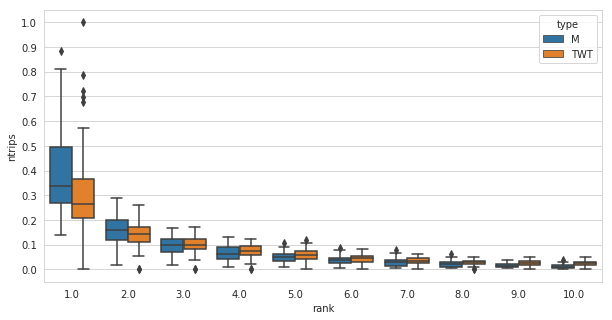

In [252]:
rank_to_plot_df = rank_df[rank_df['rank']<=10]
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
g=sns.boxplot(data=rank_to_plot_df, x='rank', y='ntrips', hue='type');
g.set_yticks(np.arange(0,1.1,0.1))

plt.savefig(os.path.join('figs', 'dist_trips_rank.png'))

In [253]:
np.arange(0,30,3)

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27])

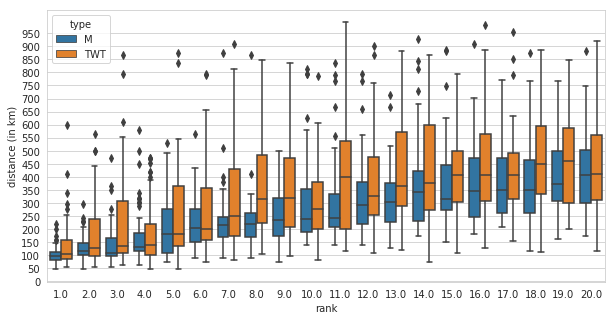

In [254]:
rank_to_plot_df = rank_df[rank_df['rank']<=20]
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
g= sns.boxplot(data=rank_to_plot_df, x='rank', y='distance (in km)', hue='type');
g.set_yticks(np.arange(0,1000,50))
plt.savefig(os.path.join('figs', 'dist_trips_rank_distance.png'))

In [255]:
rank_to_plot_df[(rank_to_plot_df['rank']==10)& (rank_to_plot_df['type']=='M')].describe()

,ntrips,rank,distance (in km)
count,49.000000,49.0,49.000000
mean,0.013549,10.0,302.228617
std,0.007842,0.0,168.137691
min,0.002243,10.0,139.022910
25%,0.006866,10.0,187.458898
50%,0.011584,10.0,239.582507
75%,0.017387,10.0,352.452784
max,0.036902,10.0,812.700777


In [256]:
rank_to_plot_df[(rank_to_plot_df['rank']==10)& (rank_to_plot_df['type']=='TWT')].describe()

,ntrips,rank,distance (in km)
count,49.000000,49.0,49.000000
mean,0.023862,10.0,301.634104
std,0.010908,0.0,150.118405
min,0.000000,10.0,82.299735
25%,0.016129,10.0,202.559835
50%,0.024390,10.0,278.826629
75%,0.030488,10.0,381.416092
max,0.050000,10.0,785.854301


In [257]:
rank_to_plot_df[(rank_to_plot_df['rank']==1)& (rank_to_plot_df['type']=='M')].describe()

,ntrips,rank,distance (in km)
count,49.000000,49.0,49.000000
mean,0.401434,1.0,103.137255
std,0.188705,0.0,34.066048
min,0.137782,1.0,46.047449
25%,0.270587,1.0,82.299735
50%,0.337635,1.0,96.050400
75%,0.495455,1.0,111.275236
max,0.883597,1.0,218.119613


In [258]:
rank_to_plot_df[(rank_to_plot_df['rank']==1)& (rank_to_plot_df['type']=='TWT')].describe()

,ntrips,rank,distance (in km)
count,49.000000,49.0,49.000000
mean,0.333654,1.0,143.101459
std,0.192146,0.0,101.569240
min,0.000000,1.0,54.429677
25%,0.209677,1.0,84.244012
50%,0.266667,1.0,104.486648
75%,0.365854,1.0,158.138385
max,1.000000,1.0,599.599953


In [259]:
gt_rank_df = gt_od_w_names_df[gt_od_w_names_df['norm_trips_rank']<=15].reset_index()['norm_trips PROV_o norm_trips_rank'.split()]
gt_rank_df = gt_rank_df.set_index('norm_trips_rank PROV_o'.split())['norm_trips'].unstack()

gt_rank_df.head()

# 4.2 Twitter based rank

In [260]:
gt_aux_od_df = gt_od_w_names_df.drop_duplicates(subset='PROV_o tw_trips_rank'.split())
gt_aux_od_df.head()

,,total_trips,norm_trips,PROV_o,PROV_d,distance,pob_o,tw_n_trips,tw_n_trips_norm,norm_trips_rank,tw_trips_rank
CPROV_o,CPROV_d,,,,,,,,,,
1,2,186.866,0.000466,Araba/Álava,Albacete,449.475826,331549.0,0.0,0.000000,45.0,17.0
3,2,82287.488,0.057087,Alacant/Alicante,Albacete,128.697310,1858683.0,4.0,0.058824,4.0,5.0
4,2,3247.865,0.009363,Almería,Albacete,183.628143,716820.0,0.0,0.000000,14.0,16.0
5,2,471.007,0.001318,Ávila,Albacete,319.635676,157640.0,0.0,0.000000,31.0,9.0
6,2,541.672,0.001992,Badajoz,Albacete,361.923358,673559.0,0.0,0.000000,29.0,14.0


In [261]:
tw_rank_df = gt_aux_od_df[gt_aux_od_df['tw_trips_rank']<=15].reset_index()['tw_n_trips PROV_o tw_trips_rank'.split()]
tw_rank_df = tw_rank_df.set_index('tw_trips_rank PROV_o'.split())['tw_n_trips'].unstack().add_prefix('tw_')

In [262]:
tw_rank_df.head()

PROV_o,tw_A Coruña,tw_Alacant/Alicante,tw_Albacete,tw_Almería,tw_Araba/Álava,tw_Asturias,tw_Badajoz,tw_Barcelona,tw_Bizkaia,tw_Burgos,tw_Cantabria,tw_Castelló/Castellón,tw_Ceuta,tw_Ciudad Real,tw_Cuenca,tw_Cáceres,tw_Cádiz,tw_Córdoba,tw_Gipuzkoa,tw_Girona,tw_Granada,tw_Guadalajara,tw_Huelva,tw_Huesca,tw_Jaén,tw_La Rioja,tw_León,tw_Lleida,tw_Lugo,tw_Madrid,tw_Melilla,tw_Murcia,tw_Málaga,tw_Navarra,tw_Ourense,tw_Palencia,tw_Pontevedra,tw_Salamanca,tw_Segovia,tw_Sevilla,tw_Soria,tw_Tarragona,tw_Teruel,tw_Toledo,tw_Valladolid,tw_València/Valencia,tw_Zamora,tw_Zaragoza,tw_Ávila
tw_trips_rank,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,15.0,18.0,10.0,5.0,7.0,5.0,8.0,86.0,13.0,19.0,14.0,15.0,1.0,28.0,37.0,14.0,30.0,9.0,19.0,74.0,22.0,43.0,52.0,19.0,22.0,5.0,10.0,28.0,10.0,93.0,0.0,7.0,18.0,12.0,8.0,8.0,10.0,17.0,42.0,39.0,4.0,49.0,10.0,87.0,18.0,24.0,12.0,29.0,23.0
2.0,7.0,10.0,10.0,4.0,5.0,5.0,6.0,53.0,11.0,10.0,6.0,5.0,0.0,12.0,18.0,8.0,17.0,7.0,4.0,5.0,10.0,7.0,4.0,6.0,12.0,3.0,6.0,6.0,5.0,48.0,0.0,6.0,11.0,9.0,6.0,7.0,5.0,11.0,4.0,18.0,4.0,5.0,4.0,11.0,15.0,16.0,8.0,22.0,5.0
3.0,5.0,8.0,7.0,3.0,4.0,3.0,4.0,53.0,7.0,8.0,5.0,4.0,0.0,9.0,11.0,4.0,3.0,7.0,2.0,4.0,8.0,4.0,3.0,5.0,6.0,3.0,6.0,5.0,4.0,46.0,0.0,5.0,10.0,5.0,4.0,5.0,3.0,8.0,4.0,17.0,2.0,5.0,3.0,5.0,12.0,14.0,8.0,11.0,4.0
4.0,5.0,5.0,3.0,2.0,4.0,2.0,3.0,21.0,7.0,7.0,5.0,3.0,0.0,7.0,11.0,4.0,3.0,6.0,2.0,2.0,8.0,2.0,2.0,4.0,6.0,1.0,4.0,4.0,3.0,40.0,0.0,2.0,9.0,4.0,3.0,5.0,2.0,6.0,3.0,16.0,2.0,4.0,3.0,3.0,6.0,9.0,5.0,7.0,3.0
5.0,4.0,4.0,2.0,2.0,3.0,1.0,2.0,13.0,5.0,6.0,4.0,2.0,0.0,6.0,5.0,2.0,2.0,6.0,1.0,1.0,7.0,2.0,1.0,3.0,3.0,1.0,4.0,3.0,3.0,39.0,0.0,2.0,5.0,4.0,2.0,2.0,2.0,6.0,2.0,14.0,2.0,3.0,3.0,2.0,5.0,7.0,5.0,7.0,2.0


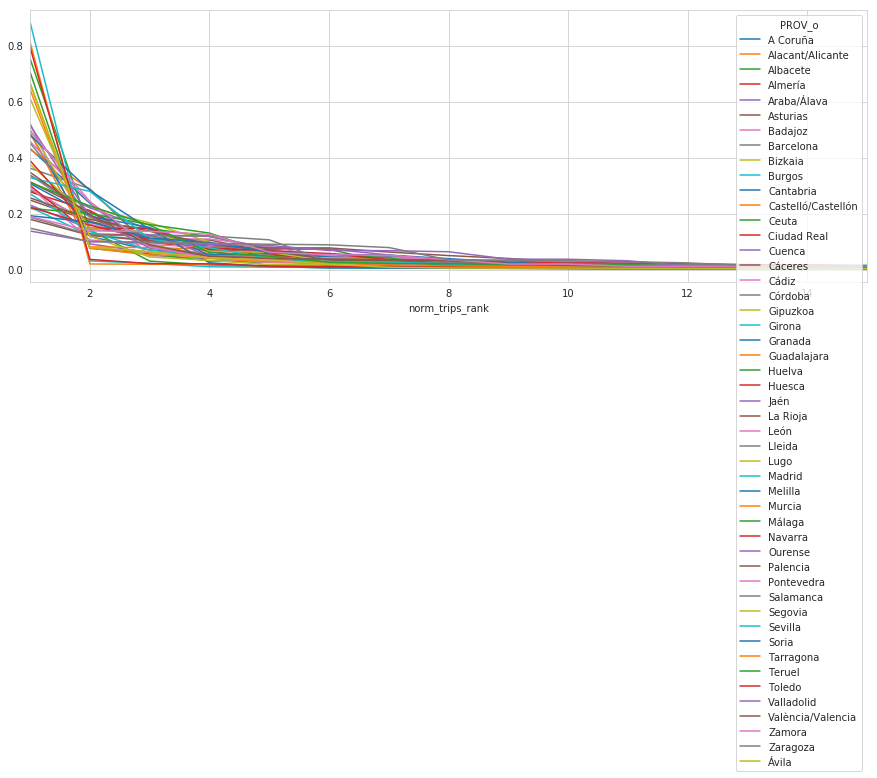

In [263]:
gt_rank_df.plot(grid=True, figsize=(15,5));

In [264]:
gt_od_w_names_df.set_index('norm_trips_rank')

,total_trips,norm_trips,PROV_o,PROV_d,distance,pob_o,tw_n_trips,tw_n_trips_norm,tw_trips_rank
norm_trips_rank,,,,,,,,,
45.0,186.866,0.000466,Araba/Álava,Albacete,449.475826,331549.0,0.0,0.000000,17.0
4.0,82287.488,0.057087,Alacant/Alicante,Albacete,128.697310,1858683.0,4.0,0.058824,5.0
14.0,3247.865,0.009363,Almería,Albacete,183.628143,716820.0,0.0,0.000000,16.0
31.0,471.007,0.001318,Ávila,Albacete,319.635676,157640.0,0.0,0.000000,9.0
29.0,541.672,0.001992,Badajoz,Albacete,361.923358,673559.0,0.0,0.000000,14.0
34.0,4225.352,0.001797,Barcelona,Albacete,466.752137,5664579.0,0.0,0.000000,34.0
39.0,753.523,0.001965,Burgos,Albacete,415.912502,356958.0,1.0,0.010753,15.0
41.0,267.326,0.001069,Cáceres,Albacete,373.821540,394151.0,0.0,0.000000,18.0
30.0,761.592,0.001092,Cádiz,Albacete,417.820042,1240155.0,0.0,0.000000,14.0


In [265]:
df = gt_od_w_names_df.reset_index()['CPROV_o norm_trips norm_trips_rank'.split()].set_index('norm_trips_rank')

In [266]:
df

,CPROV_o,norm_trips
norm_trips_rank,,
45.0,1,0.000466
4.0,3,0.057087
14.0,4,0.009363
31.0,5,0.001318
29.0,6,0.001992
34.0,8,0.001797
39.0,9,0.001965
41.0,10,0.001069
30.0,11,0.001092


### 4.3 Plot results

In [267]:
gt_od_w_names_df['norm_trips norm_trips_rank'.split()].T

CPROV_o,1,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,1,2,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,1,2,3,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,1,2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,1,2,3,4,5,6,9,10,11,12,13,...,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,49,50,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,48,50,51,52,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,48,49,51,52,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,28,29,30,31,33,34,36,37,41,43,44,45,46,47,48,49,50,52,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,3,4,6,8,9,10,11,12,13,14,15,16,17,18,26,28,29,30,33,34,37,40,41,43,45,46,47,50,51
CPROV_d,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,8,8,8,8,8,8,8,8,8,8,8,...,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
norm_trips,0.000466,0.057087,0.009363,0.001318,0.001992,0.001797,0.001965,0.001069,0.001092,0.008875,0.062881,0.002554,0.000739,0.142941,0.000557,0.003132,0.003011,0.000423,0.000754,0.000485,0.01809,0.001322,0.00047,0.000653,0.000397,0.006671,0.001035,0.052024,0.001001,0.000711,0.001048,0.0008,0.000331,0.001591,0.000467,0.001915,0.001133,0.002274,0.001443,0.0042,0.005895,0.035563,0.001627,0.000309,0.001189,0.000924,0.000825,0.005188,0.283923,0.052602,0.00541,0.005548,0.009964,0.008058,0.006474,0.003067,0.039208,0.042794,0.005463,0.003182,0.039479,0.004282,0.022891,0.007746,0.004278,0.001166,0.004575,0.015519,0.00711,0.002898,0.00894,0.001269,0.039793,0.008105,0.643376,0.009685,0.00207,0.006564,0.006947,0.001416,0.010243,0.002819,0.007977,0.003381,0.004769,0.008326,0.026037,0.012417,0.347566,0.013102,0.005602,0.004368,0.012057,0.001928,0.004451,0.000923,0.011343,0.012538,0.001292,0.004937,0.004182,0.001661,0.001805,0.007942,0.004333,0.012383,0.017872,0.000832,0.004567,0.000699,0.190815,0.001614,0.000887,0.003289,0.000379,0.073717,0.00124,0.000702,0.001031,0.00034,0.008766,0.04151,0.076496,0.001344,0.000632,0.001494,0.000838,0.000545,0.001476,0.00051,0.001348,0.010749,0.001159,0.002265,0.002592,0.003238,0.007865,0.002132,0.000965,0.001426,0.00182,0.002568,0.480211,0.000979,0.001444,0.001527,0.001242,0.006474,0.000623,0.004097,0.0299

In [268]:
ax=None
for prov_o in gt_od_w_names_df['PROV_o'].unique():
    #print(prov_o)
    df = gt_od_w_names_df[gt_od_w_names_df['PROV_o']==prov_o]['norm_trips norm_trips_rank'.split()]
    df = df.set_index('norm_trips_rank')
    if ax:
        df.plot()

# 5. Number of trips comparative

In [269]:
gt_n_trips= gt_od_w_names_df.groupby('PROV_o').size().to_frame()

In [270]:
tw_n_trips= tw_od_w_codes_df.groupby('PROV_o').size().to_frame()

In [271]:
gt_n_trips['tw_n_trips']= tw_n_trips[0]

In [272]:
gt_n_trips.head()

,0,tw_n_trips
PROV_o,,
A Coruña,48,11.0
Alacant/Alicante,48,21.0
Albacete,47,15.0
Almería,48,16.0
Araba/Álava,47,17.0


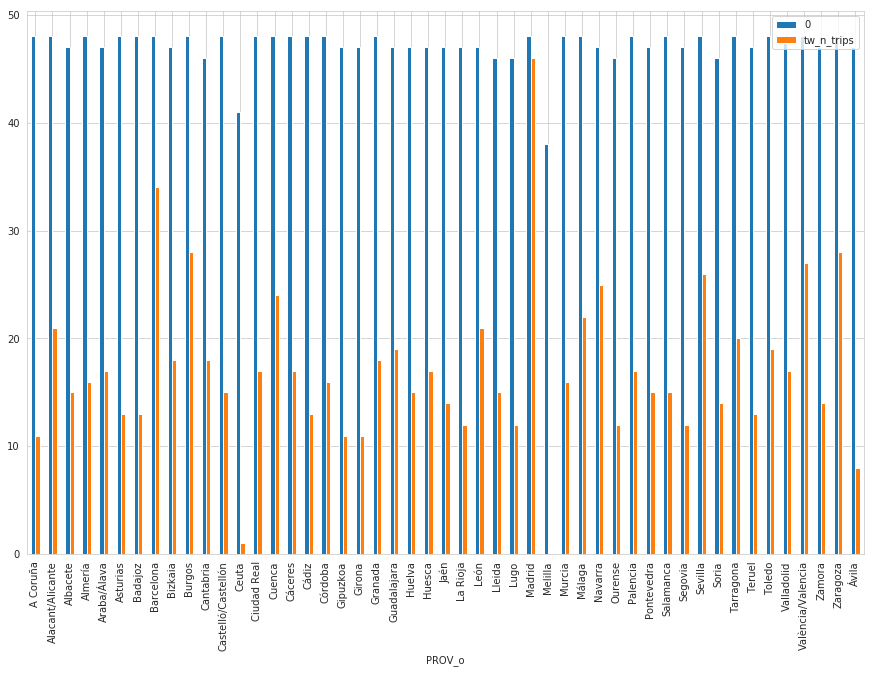

In [273]:
gt_n_trips.plot(kind='bar', grid=True, figsize=(15,10));

# 6. Graph-based comparative

In [274]:
import networkx as nx

### 6.1 Ground truth

In [275]:
gt_od_w_names_df.shape

(2308, 10)

In [276]:
G_gt = nx.DiGraph()

for i, r in gt_od_w_names_df.reset_index().iterrows():
   # print(i,r['CPROV_o'], r['CPROV_d'], r['norm_trips'])
    G_gt.add_edge(r['PROV_o'], r['PROV_d'], weight=r['norm_trips'])

In [277]:
G_gt.number_of_nodes()

49

In [278]:
G_gt.number_of_edges()

2308

In [279]:
deg_centrality_gt = nx.degree_centrality(G_gt) 

In [280]:
gt_deg_df =  pd.DataFrame(list(deg_centrality_gt.items()),columns = ['PROV','gta_deg'])
gt_deg_df.set_index(['PROV'], inplace=True)

In [281]:
gt_deg_df.head()

,gta_deg
PROV,
Araba/Álava,1.979167
Albacete,1.958333
Alacant/Alicante,2.000000
Almería,2.000000
Ávila,1.979167


## 6.2 Twitter 

In [282]:
tw_inter_od_w_codes_df = tw_od_w_codes_df[tw_od_w_codes_df['PROV_o']!= tw_od_w_codes_df['PROV_d']]

In [283]:
tw_inter_od_w_codes_df.head()

,,PROV_o,PROV_d,n_trips,n_trips_norm,distance,pob_o,gt_norm_trips
CPROV_o,CPROV_d,,,,,,,
15,1,A Coruña,Araba/Álava,1,0.022727,469.926541,1119596.0,0.000891
8,1,Barcelona,Araba/Álava,2,0.006472,406.977101,5664579.0,0.001722
48,1,Bizkaia,Araba/Álava,5,0.080645,46.047449,1152651.0,0.221205
9,1,Burgos,Araba/Álava,5,0.053763,88.068059,356958.0,0.049137
39,1,Cantabria,Araba/Álava,1,0.020833,114.115095,581078.0,0.029992


In [284]:
tw_inter_od_w_codes_df.shape

(852, 7)

In [285]:
G_tw = nx.DiGraph()

for i, r in tw_inter_od_w_codes_df.iterrows():
    #print(r['PROV_o'], r['PROV_d'])
    G_tw.add_edge(r['PROV_o'], r['PROV_d'], weight=r['n_trips_norm'])

In [286]:
G_tw.number_of_nodes()    


49

In [287]:
G_tw.number_of_edges()

852

In [288]:
deg_centrality_tw = nx.degree_centrality(G_tw) 

In [289]:
tw_deg_df =  pd.DataFrame(list(deg_centrality_tw.items()),columns = ['PROV','tw_deg'])
tw_deg_df.set_index(['PROV'], inplace=True)

In [290]:
tw_deg_df.head()

,tw_deg
PROV,
A Coruña,0.562500
Araba/Álava,0.770833
Barcelona,1.312500
Bizkaia,0.750000
Burgos,0.979167


In [291]:
gt_deg_df['tw_deg'] = tw_deg_df['tw_deg']
gt_deg_df.fillna(0, axis=1, inplace=True)
gt_deg_df.head()

,gta_deg,tw_deg
PROV,,
Araba/Álava,1.979167,0.770833
Albacete,1.958333,0.583333
Alacant/Alicante,2.000000,0.875000
Almería,2.000000,0.666667
Ávila,1.979167,0.416667


In [292]:
corr_= gt_deg_df['gta_deg'].corr(gt_deg_df['tw_deg'])
rmse = mean_squared_error(gt_deg_df['gta_deg'], gt_deg_df['tw_deg'])
print(corr_,rmse)

0.5349141825114445 1.6299603174603174


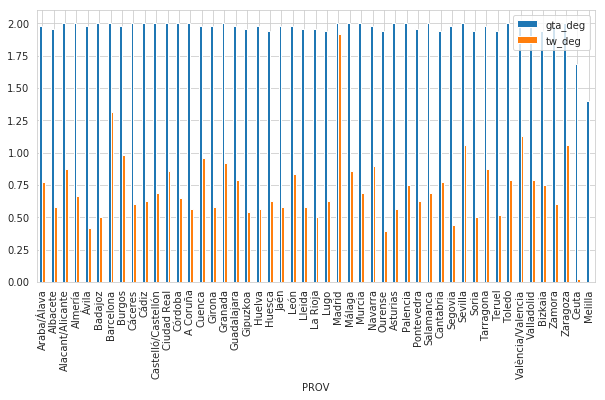

In [293]:
gt_deg_df.plot(kind='bar', figsize=(10,5), grid=True);

In [294]:
from sklearn import preprocessing

In [295]:
min_max_scaler = preprocessing.MinMaxScaler()

deg_scaled = min_max_scaler.fit_transform(gt_deg_df[['gta_deg']].values)
gt_deg_df['gt_deg_norm'] = deg_scaled
deg_scaled = min_max_scaler.fit_transform(gt_deg_df[['tw_deg']].values)
gt_deg_df['tw_deg_norm'] = deg_scaled

In [296]:
gt_deg_df.head()

,gta_deg,tw_deg,gt_deg_norm,tw_deg_norm
PROV,,,,
Araba/Álava,1.979167,0.770833,0.965517,0.402174
Albacete,1.958333,0.583333,0.931034,0.304348
Alacant/Alicante,2.000000,0.875000,1.000000,0.456522
Almería,2.000000,0.666667,1.000000,0.347826
Ávila,1.979167,0.416667,0.965517,0.217391


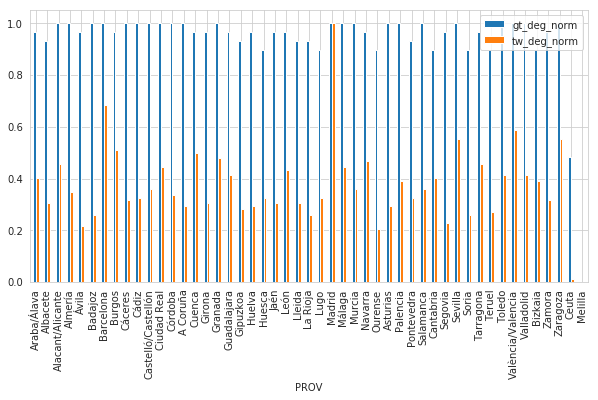

In [297]:
gt_deg_df['gt_deg_norm tw_deg_norm'.split()].plot(kind='bar', grid=True, figsize=(10,5));

# 7. Comparison by transport mode

In [298]:
tm_od_df = pd.read_csv(os.path.join('data', 'Julio_Modo_ProvinciaxProvincia.csv'), 
                          sep=';', 
                          converters={3: lambda x: float(x.replace('.','').replace(',','.')),
                                     4: lambda x: float(x.replace('.','').replace(',','.'))},
                          encoding = "ISO-8859-1",
                         header=None)
tm_od_df.columns= 'transport_mode CPROV_o CPROV_d n_trips n_trips_norm total_trips_PROV_o'.split()
tm_od_df.head()

,transport_mode,CPROV_o,CPROV_d,n_trips,n_trips_norm,total_trips_PROV_o
0,autobús,1,3,271.382,0.082912,"3273,147"
1,autobús,1,8,217.525,0.066457,"3273,147"
2,autobús,1,9,322.878,0.098645,"3273,147"
3,autobús,1,10,14.311,0.004372,"3273,147"
4,autobús,1,11,27.083,0.008274,"3273,147"


In [299]:
tm_od_enrich_df= enrich_od_matrix_fn(tm_od_df)

In [300]:
tm_od_enrich_df['tw_n_trips']= tw_od_w_codes_df['n_trips']
tm_od_enrich_df['tw_n_trips_norm']= tw_od_w_codes_df['n_trips_norm']
tm_od_enrich_df.fillna(0, axis=1,inplace=True)

In [301]:
tm_od_enrich_df['n_trips']= tm_od_enrich_df['n_trips'].astype(np.float64)
tm_od_enrich_df['n_trips_norm']= tm_od_enrich_df['n_trips_norm'].astype(np.float64)

In [302]:
total_trips_by_tm_df=tm_od_enrich_df.groupby(['CPROV_o', 'transport_mode'])['n_trips'].sum().to_frame()
total_trips_by_tm_df.head(10)

n_trips
CPROV_o transport_mode            
1       autobús           3273.147
        avión             1188.481
        barco                4.492
        carretera       242713.189
        privado         145914.681
        tren              6956.252
2       autobús           3685.736
        avión              110.828
        barco                2.131
        carretera        63859.093

In [303]:
def get_norm_trips_by_tm_fm(row):
    cprov_o = row.name[0]#row['CPROV_o']
    tm = row['transport_mode']
    total_trips = total_trips_by_tm_df.loc[(cprov_o,tm)]
    return row['n_trips']/total_trips

In [304]:
tm_od_enrich_df

index transport_mode     n_trips  n_trips_norm total_trips_PROV_o              PROV_o            PROV_d    distance      pob_o  tw_n_trips  tw_n_trips_norm
CPROV_o CPROV_d                                                                                                                                                             
1       3            0        autobús     271.382      0.082912           3273,147         Araba/Álava  Alacant/Alicante  516.687639   331549.0         0.0         0.000000
        3          842          avión     128.735      0.074259           1733,583         Araba/Álava  Alacant/Alicante  516.687639   331549.0         0.0         0.000000
        3         3503        privado    1676.583      0.011490         145914,681         Araba/Álava  Alacant/Alicante  516.687639   331549.0         0.0         0.000000
        3         5567           tren       1.860      0.000267           6956,252         Araba/Álava  Alacant/Alicante  516.687639   331549.0         0.0         0.000000
2       3           22        autobús     926.980      0.251505           3685,736            Albacete  Alacant/Alicante  128.697310   388167.0         3.0         0.066667
        3         3547        privado   83451.434      0.375474         222256,405            Albacete  Alacant/Alicante  128.697310   388167.0         3.0         0.066667
        3         5599           tren    1247.638      0.109534          11390,388            Albacete  Alacant/Alicante  128.697310   388167.0         3.0         0.066667
4       3           63        autobús     328.186      0.072097           4552,033             Almería  Alacant/Alicante  211.413921   716820.0         2.0         0.074074
        3         3637        privado   17910.879      0.125966         142188,379             Almería  Alacant/Alicante  211.413921   716820.0         2.0         0.074074
        3         5670           tren       6.535      0.000713           9171,353             Almería  Alacant/Alicante  211.413921   716820.0         2.0         0.074074
5       3         3677        privado    1717.179      0.006115         280813,556               Ávila  Alacant/Alicante  442.033338   157640.0         0.0         0.000000
        3         5704           tren     216.445      0.026211           8257,744               Ávila  Alacant/Alicante  442.033338   157640.0         0.0         0.000000
6       3           82        autobús      20.158      0.004117           4896,558             Badajoz  Alacant/Alicante  486.113390   673559.0         0.0         0.000000
        3         3715        privado    1488.420      0.008012         185776,555             Badajoz  Alacant/Alicante  486.113390   673559.0         0.0         0.000000
8       3          105        autobús     301.097      0.016940          17774,209           Barcelona  Alacant/Alicante  421.955202  5664579.0         5.0         0.016181
        3         1002          avión    2402.600      0.019332         124282,436           Barcelona  Alacant/Alicante  421.955202  5664579.0         5.0         0.016181
        3         3760        privado   14074.743      0.040974         343505,659           Barcelona  Alacant/Alicante  421.955202  5664579.0         5.0         0.016181
        3         5758           tren    6646.974      0.036401         182605,235           Barcelona  Alacant/Alicante  421.955202  5664579.0         5.0         0.016181
9       3         1053          avión      32.742      0.048532            674,654              Burgos  Alacant/Alicante  501.743421   356958.0         0.0         0.000000
        3         2684          barco       1.539      0.014506            106,097              Burgos  Alacant/Alicante  501.743421   356958.0         0.0         0.000000
        3         3804        privado    3039.292      0.011267         269741,736              Burgos  Alacant/Alicante  501.743421   356958.0         0.0         0.000000
        3         5803           tren 

In [305]:
tm_od_enrich_df['n_trips_norm_by_tm'] = tm_od_enrich_df.apply(get_norm_trips_by_tm_fm, axis=1)

In [306]:
tm_od_enrich_df.head(10)

index transport_mode    n_trips  n_trips_norm total_trips_PROV_o       PROV_o            PROV_d    distance     pob_o  tw_n_trips  tw_n_trips_norm  n_trips_norm_by_tm
CPROV_o CPROV_d                                                                                                                                                                        
1       3            0        autobús    271.382      0.082912           3273,147  Araba/Álava  Alacant/Alicante  516.687639  331549.0         0.0         0.000000            0.082912
        3          842          avión    128.735      0.074259           1733,583  Araba/Álava  Alacant/Alicante  516.687639  331549.0         0.0         0.000000            0.108319
        3         3503        privado   1676.583      0.011490         145914,681  Araba/Álava  Alacant/Alicante  516.687639  331549.0         0.0         0.000000            0.011490
        3         5567           tren      1.860      0.000267           6956,252  Araba/Álava  Alacant/Alicante  516.687639  331549.0         0.0         0.000000            0.000267
2       3           22        autobús    926.980      0.251505           3685,736     Albacete  Alacant/Alicante  128.697310  388167.0         3.0         0.066667            0.251505
        3         3547        privado  83451.434      0.375474         222256,405     Albacete  Alacant/Alicante  128.697310  388167.0         3.0         0.066667            0.375474
        3         5599           tren   1247.638      0.109534          11390,388     Albacete  Alacant/Alicante  128.697310  388167.0         3.0         0.066667            0.109534
4       3           63        autobús    328.186      0.072097           4552,033      Almería  Alacant/Alicante  211.413921  716820.0         2.0         0.074074            0.072097
        3         3637        privado  17910.879      0.125966         142188,379      Almería  Alacant/Alicante  211.413921  716820.0         2.0         0.074074            0.125976
        3         5670           tren      6.535      0.000713           9171,353      Almería  Alacant/Alicante  211.413921  716820.0         2.0         0.074074            0.000713

In [307]:
tm_od_enrich_df.to_csv(os.path.join('data', 'july_gt_od_w_transport_mode.csv'))

In [308]:
tm_od_df_ = tm_od_enrich_df[tm_od_enrich_df['transport_mode']!='privado']
tm_od_df_['transport_mode'] = tm_od_df_['transport_mode'].map({'tren': 'train', 'autobús': 'bus', 'barco':'ship', 'avión':'plane', 'carretera': 'car', 'privado':'private'})

/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [309]:
tm_od_df_

index transport_mode     n_trips  n_trips_norm total_trips_PROV_o              PROV_o            PROV_d    distance      pob_o  tw_n_trips  tw_n_trips_norm  n_trips_norm_by_tm
CPROV_o CPROV_d                                                                                                                                                                                 
1       3            0            bus     271.382      0.082912           3273,147         Araba/Álava  Alacant/Alicante  516.687639   331549.0         0.0         0.000000            0.082912
        3          842          plane     128.735      0.074259           1733,583         Araba/Álava  Alacant/Alicante  516.687639   331549.0         0.0         0.000000            0.108319
        3         5567          train       1.860      0.000267           6956,252         Araba/Álava  Alacant/Alicante  516.687639   331549.0         0.0         0.000000            0.000267
2       3           22            bus     926.980      0.251505           3685,736            Albacete  Alacant/Alicante  128.697310   388167.0         3.0         0.066667            0.251505
        3         5599          train    1247.638      0.109534          11390,388            Albacete  Alacant/Alicante  128.697310   388167.0         3.0         0.066667            0.109534
4       3           63            bus     328.186      0.072097           4552,033             Almería  Alacant/Alicante  211.413921   716820.0         2.0         0.074074            0.072097
        3         5670          train       6.535      0.000713           9171,353             Almería  Alacant/Alicante  211.413921   716820.0         2.0         0.074074            0.000713
5       3         5704          train     216.445      0.026211           8257,744               Ávila  Alacant/Alicante  442.033338   157640.0         0.0         0.000000            0.026211
6       3           82            bus      20.158      0.004117           4896,558             Badajoz  Alacant/Alicante  486.113390   673559.0         0.0         0.000000            0.004117
8       3          105            bus     301.097      0.016940          17774,209           Barcelona  Alacant/Alicante  421.955202  5664579.0         5.0         0.016181            0.016940
        3         1002          plane    2402.600      0.019332         124282,436           Barcelona  Alacant/Alicante  421.955202  5664579.0         5.0         0.016181            0.037903
        3         5758          train    6646.974      0.036401         182605,235           Barcelona  Alacant/Alicante  421.955202  5664579.0         5.0         0.016181            0.036401
9       3         1053          plane      32.742      0.048532            674,654              Burgos  Alacant/Alicante  501.743421   356958.0         0.0         0.000000            0.074394
        3         2684           ship       1.539      0.014506            106,097              Burgos  Alacant/Alicante  501.743421   356958.0         0.0         0.000000            0.056589
        3         5803          train      17.095      0.003661           4669,109              Burgos  Alacant/Alicante  501.743421   356958.0         0.0         0.000000            0.003661
10      3          165            bus       2.486      0.000716           3471,628             Cáceres  Alacant/Alicante  502.516685   394151.0         0.0         0.000000            0.000716
        3         5839          train      24.208      0.005687           4256,487             Cáceres  Alacant/Alicante  502.516685   394151.0         0.0         0.000000            0.005687
11      3          187            bus       2.414      0.000746           3234,865               Cádiz  Alacant/Alicante  505.969912  1240155.0         0.0         0.000000            0.000746
        3         1091          plane      19.340      0.002381           8122,457               Cádiz  Alacant/Alicante  505.969912  1240155.0         0.0  

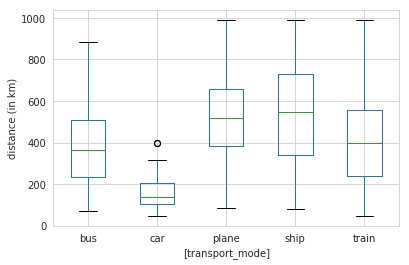

In [310]:
fig= tm_od_df_['transport_mode distance'.split()].boxplot(by='transport_mode').get_figure();
plt.title('')
plt.suptitle('') # that's what you're after
plt.ylabel('distance (in km)')
fig.savefig(os.path.join('figs','transpot_mode_distribution.png'));
plt.show()


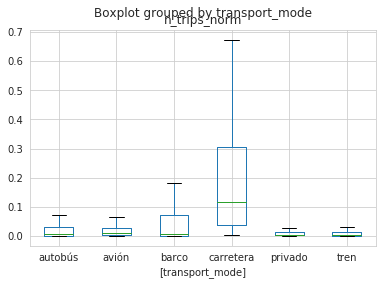

In [311]:
tm_od_enrich_df['transport_mode n_trips_norm'.split()].boxplot(by='transport_mode', showfliers=False);

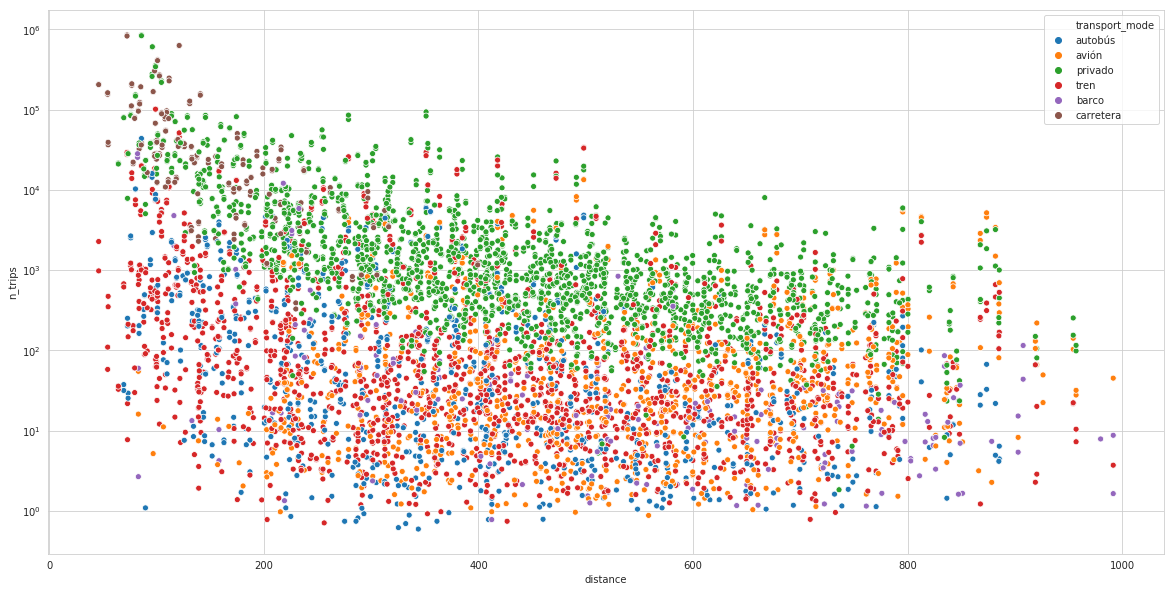

In [312]:
plt.figure(figsize=(20,10));
grid= sns.scatterplot(data=tm_od_enrich_df,x='distance', y='n_trips', hue='transport_mode');
grid.set(yscale="log");

In [313]:
tm_results = []
for tm in tm_od_enrich_df['transport_mode'].unique():
    t_od_df = tm_od_enrich_df[tm_od_enrich_df['transport_mode']==tm]
    if not t_od_df.empty:
        corr_= t_od_df['n_trips_norm'].corr(t_od_df['tw_n_trips_norm'])
        rmse = mean_squared_error(t_od_df['n_trips_norm'], t_od_df['tw_n_trips_norm'],squared=False)
        tm_results.append((tm,corr_, rmse))

In [314]:
tm_results_df = pd.DataFrame.from_records(tm_results)
tm_results_df.set_index(0, inplace=True)
tm_results_df.columns = 'corr RMSE'.split()
tm_results_df.head()

,corr,RMSE
0,,
autobús,0.718257,0.111620
avión,0.300307,0.070623
privado,0.665843,0.056876
tren,0.714510,0.065714
barco,-0.062285,0.244815


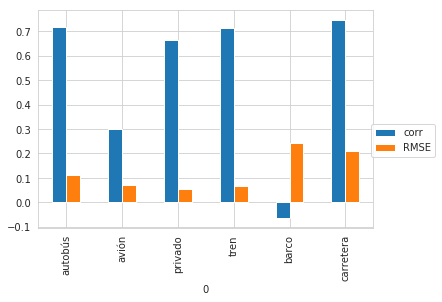

In [315]:
tm_results_df.plot(kind='bar', grid=True).legend(bbox_to_anchor=(1.2, 0.5));